In [155]:
import json
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision.models import vgg19
import torch
from torch.utils import data as data_utils


columns = ['opp_switch', 'opp_damage_dealt', 'opp_effectiveness', 'opp_damage_taken', 'opp_heal', 'opp_faint', 'opp_boost_off', 'opp_boost_def', 'opp_boost_spe', 'opp_unboost_off', 'opp_unboost_def', 'opp_unboost_spe', 'opp_basepower', 'opp_accuracy', 'opp_stab', 'opp_priority', 'opp_first', 'switch', 'damage_dealt', 'effectiveness', 'damage_taken', 'heal', 'faint', 'boost_off', 'boost_def', 'boost_spe', 'unboost_off', 'unboost_def', 'unboost_spe', 'basepower', 'accuracy', 'stab', 'priority', 'first', 'turn', 'turn_norm', 'opp_alive', 'alive', 'weight', 'winner', 'opp_winner', 'opp_usage']


In [317]:
with open('datasets/clean/images.json') as fl:
  _data = json.load(fl)

train_images, train_labels, train_poke = list(zip(
  *[(np.array(img), label, poke) for img, label, poke in
    zip(_data['train_images'], _data['train_labels'], _data['train_poke'])
    if np.array(img).shape == np.array(_data['train_images'][0]).shape]
))

test_images, test_labels, test_poke = zip(
	*[(np.array(img), label, poke) for img, label, poke in
	  zip(_data['test_images'], _data['test_labels'], _data['test_poke'])
    if np.array(img).shape == np.array(_data['test_images'][0]).shape]
)

train_labels, test_labels = np.array(train_labels), np.array(test_labels)

In [318]:
print(len(train_images))
print(len(_data['train_images']))
print(len(test_images))
print(len(_data['test_images']))


1562
1562
460
460


In [319]:
train_images[0].shape

(8, 42)

,opp_switch,opp_damage_dealt,opp_effectiveness,opp_damage_taken,opp_heal,opp_faint,opp_boost_off,opp_boost_def,opp_boost_spe,opp_unboost_off,...,priority,first,turn,turn_norm,opp_alive,alive,weight,winner,opp_winner,opp_usage
0,1.000000,0.757631,0.950904,0.776927,0.600341,0.261888,0.922790,0.845630,0.903976,0.991202,...,0.341490,0.982375,0.164484,0.154435,1.000000,1.000000,1.000000,0.998276,0.988797,0.976687
1,0.771986,0.789226,0.953705,0.789666,0.763263,0.356856,0.979682,1.000000,0.976758,0.925953,...,0.407701,0.963289,0.284779,0.277350,0.950037,0.951582,0.997491,0.987645,1.000000,0.994230
2,0.712841,0.802194,0.952569,0.807414,0.862134,0.417025,1.000000,0.998865,1.000000,0.934018,...,0.466355,0.968049,0.411162,0.398150,0.896877,0.900644,0.995947,0.994413,0.992868,0.996925
3,0.694027,0.814183,0.953387,0.811047,0.895208,0.475253,0.985777,0.975028,0.944954,0.889296,...,0.662828,0.975306,0.532698,0.516706,0.835290,0.839257,0.994820,0.993296,0.994045,0.992717
4,0.683590,0.846446,0.959518,0.840296,0.954664,0.548870,0.971216,0.994325,0.902141,0.934751,...,0.770061,0.987606,0.650452,0.636367,0.768624,0.774469,0.992139,0.989273,0.998284,1.000000
5,0.676181,0.879166,0.965558,0.883239,1.000000,0.612505,0.949543,0.918275,0.922936,1.000000,...,0.759266,1.000000,0.780487,0.755968,0.695974,0.700597,0.994430,1.000000,0.986980,0.987450
6,0.643322,0.919019,0.979562,0.933971,0.934554,0.734369,0.968845,0.925085,0.898471,0.903226,...,0.970133,0.999246,0.907015,0.876703,0.612439,0.615792,0.993076,0.990327,0.997174,0.992106
7,0.604471,1.000000,1.000000,1.000000,0.799177,1.000000,0.771080,0.627696,0.629358,0.838710,...,1.000000,0.929783,1.000000,1.000000,0.517932,0.516574,0.986371,0.995115,0.992128,0.995038


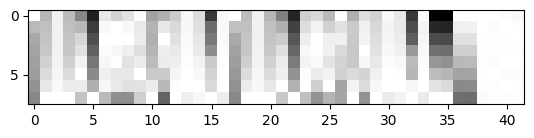

In [320]:
all_images = np.concatenate((train_images, test_images), axis=0)
img = np.mean(all_images, axis=0)
display(pd.DataFrame(img / img.max(axis=0) , columns=columns))
plt.imshow(img / img.max(axis=0), cmap='gray')

train_images = [x / img.max(axis=0) - 0.5 for x in train_images]
test_images = [x / img.max(axis=0) - 0.5 for x in test_images]
train_images, test_images = np.array(train_images), np.array(test_images)


In [321]:
print(type(train_images))
train_images = train_images.reshape(len(train_labels), 8, 42, 1)
test_images = test_images.reshape(len(test_labels), 8, 42, 1)

<class 'numpy.ndarray'>


In [322]:
import keras
from sklearn.metrics import r2_score
from keras.callbacks import EarlyStopping
from keras import Sequential

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


# cnn regression model
model = Sequential()
model.add(Conv2D(32, (4, 8), activation='relu', input_shape=(8, 42, 1), padding='same', strides=(1, 2)))
model.add(MaxPooling2D((1, 4)))
model.add(Conv2D(64, (2, 2), activation='relu', padding='same'))
model.add(MaxPooling2D((1, 2)))
model.add(Conv2D(64, (2, 2), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[r2_score], run_eagerly=True)

early_stop = EarlyStopping(monitor='val_loss', patience=4)

history = model.fit(train_images, train_labels, epochs=100, batch_size=16, validation_split=0.3, callbacks=[early_stop])

test_acc = model.evaluate(test_images, test_labels)

# r2 score
pred = model.predict(test_images)
print(r2_score(test_labels, pred))

Epoch 1/100
69/69 [==============================] - 8s 119ms/step - loss: 0.1339 - r2_score: -1.9096 - val_loss: 0.0609 - val_r2_score: -0.1358
Epoch 2/100
69/69 [==============================] - 7s 100ms/step - loss: 0.0872 - r2_score: -0.6636 - val_loss: 0.0498 - val_r2_score: 0.1102
Epoch 3/100
69/69 [==============================] - 7s 96ms/step - loss: 0.0714 - r2_score: -0.4063 - val_loss: 0.0577 - val_r2_score: -0.1728
Epoch 4/100
69/69 [==============================] - 7s 100ms/step - loss: 0.0550 - r2_score: -0.0400 - val_loss: 0.0422 - val_r2_score: 0.2240
Epoch 5/100
69/69 [==============================] - 7s 95ms/step - loss: 0.0488 - r2_score: 0.0141 - val_loss: 0.0437 - val_r2_score: 0.1277
Epoch 6/100
69/69 [==============================] - 7s 95ms/step - loss: 0.0381 - r2_score: 0.2942 - val_loss: 0.0435 - val_r2_score: 0.0686
Epoch 7/100
69/69 [==============================] - 6s 94ms/step - loss: 0.0367 - r2_score: 0.2336 - val_loss: 0.0352 - val_r2_score: 0.31

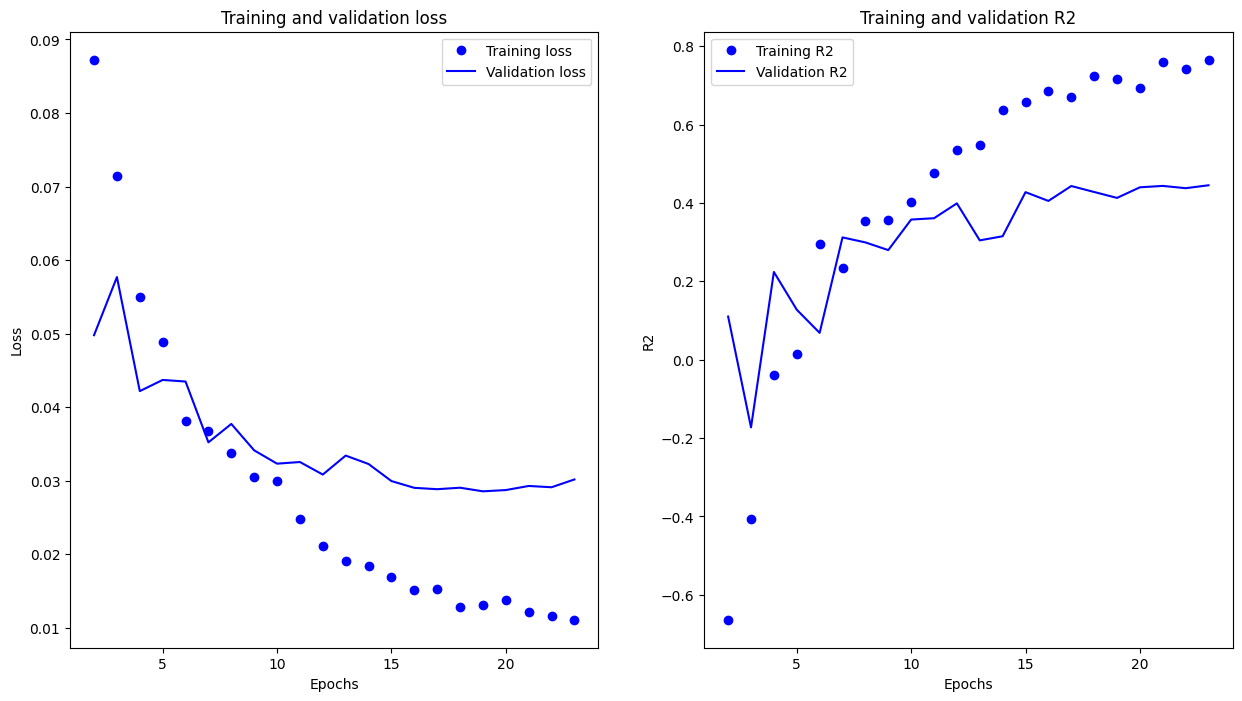

In [323]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['r2_score']
val_acc = history.history['val_r2_score']
epochs = range(1, len(train_loss) + 1)

fig, ax = plt.subplots(1, 2, figsize=(15, 8))

ax[0].plot(epochs[1:], train_loss[1:], 'bo', label='Training loss')
ax[0].plot(epochs[1:], val_loss[1:], 'b', label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs[1:], train_acc[1:], 'bo', label='Training R2')
ax[1].plot(epochs[1:], val_acc[1:], 'b', label='Validation R2')
ax[1].set_title('Training and validation R2')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('R2')
ax[1].legend()

plt.show()


In [266]:
test_poke

('Garganacl',
 'Roaring Moon',
 'Torkoal',
 'Iron Treads',
 'Garganacl',
 'Skeledirge',
 'Iron Treads',
 'Ting-Lu',
 'Roaring Moon',
 'Ceruledge',
 'Iron Treads',
 'Garganacl',
 'Torkoal',
 'Hydreigon',
 'Iron Treads',
 'Garchomp',
 'Garganacl',
 'Garganacl',
 'Roaring Moon',
 'Ting-Lu',
 'Hippowdon',
 'Hydreigon',
 'Ting-Lu',
 'Torkoal',
 'Hippowdon',
 'Volcarona',
 'Skeledirge',
 'Skeledirge',
 'Roaring Moon',
 'Ceruledge',
 'Skeledirge',
 'Skeledirge',
 'Ting-Lu',
 'Garganacl',
 'Garganacl',
 'Ceruledge',
 'Roaring Moon',
 'Garganacl',
 'Roaring Moon',
 'Hydreigon',
 'Slowking',
 'Skeledirge',
 'Slowking',
 'Ting-Lu',
 'Skeledirge',
 'Slowking',
 'Roaring Moon',
 'Slowking',
 'Skeledirge',
 'Garganacl',
 'Volcarona',
 'Volcarona',
 'Sandy Shocks',
 'Ceruledge',
 'Garchomp',
 'Skeledirge',
 'Garchomp',
 'Ceruledge',
 'Skeledirge',
 'Skeledirge',
 'Garganacl',
 'Garganacl',
 'Skeledirge',
 'Garchomp',
 'Slowking',
 'Ting-Lu',
 'Torkoal',
 'Torkoal',
 'Torkoal',
 'Volcarona',
 'Gargana

In [267]:
test_poke

('Garganacl',
 'Roaring Moon',
 'Torkoal',
 'Iron Treads',
 'Garganacl',
 'Skeledirge',
 'Iron Treads',
 'Ting-Lu',
 'Roaring Moon',
 'Ceruledge',
 'Iron Treads',
 'Garganacl',
 'Torkoal',
 'Hydreigon',
 'Iron Treads',
 'Garchomp',
 'Garganacl',
 'Garganacl',
 'Roaring Moon',
 'Ting-Lu',
 'Hippowdon',
 'Hydreigon',
 'Ting-Lu',
 'Torkoal',
 'Hippowdon',
 'Volcarona',
 'Skeledirge',
 'Skeledirge',
 'Roaring Moon',
 'Ceruledge',
 'Skeledirge',
 'Skeledirge',
 'Ting-Lu',
 'Garganacl',
 'Garganacl',
 'Ceruledge',
 'Roaring Moon',
 'Garganacl',
 'Roaring Moon',
 'Hydreigon',
 'Slowking',
 'Skeledirge',
 'Slowking',
 'Ting-Lu',
 'Skeledirge',
 'Slowking',
 'Roaring Moon',
 'Slowking',
 'Skeledirge',
 'Garganacl',
 'Volcarona',
 'Volcarona',
 'Sandy Shocks',
 'Ceruledge',
 'Garchomp',
 'Skeledirge',
 'Garchomp',
 'Ceruledge',
 'Skeledirge',
 'Skeledirge',
 'Garganacl',
 'Garganacl',
 'Skeledirge',
 'Garchomp',
 'Slowking',
 'Ting-Lu',
 'Torkoal',
 'Torkoal',
 'Torkoal',
 'Volcarona',
 'Gargana

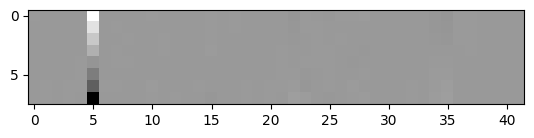

In [324]:
img = np.mean(test_images, axis=0)
plt.imshow(img / img.sum(axis=0), cmap='gray')

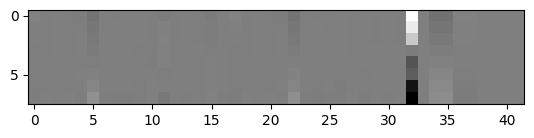

In [325]:
img = np.mean(train_images, axis=0)
plt.imshow(img / img.sum(axis=0), cmap='gray')


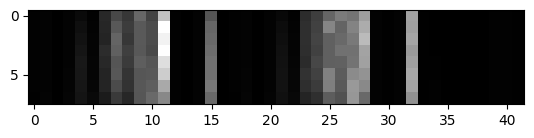

In [270]:
plt.imshow(np.var(train_images, axis=0), cmap='gray')

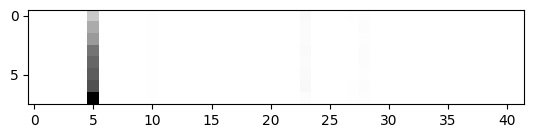

In [326]:
img = np
plt.imshow(np.var(test_images / np.sum(np.mean(test_images, axis=0), axis=0), axis=0), cmap='binary')


In [327]:
from itertools import groupby
groups = groupby(sorted(zip(test_images, test_labels, test_poke), key=lambda x: x[-1]), key=lambda x: x[-1])

pred = []
true = []

for k, v in groups:
	images = []
	for data in v:
		true_ = data[1]
		images.append(data[0])
	true.append(true_)
	pred.append(np.mean(model.predict(np.array(images))))


3/3 [==============================] - 0s 10ms/step


In [328]:
r2_score(true, pred)

-0.5120728967317305